In [1]:
import os
import numpy as np
import torch
from PIL import Image

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils

from _params import hparams
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import functional as F

from engine import train_one_epoch, evaluate
import utils
import transforms as T
import pandas as pd
from _params import hparams
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [2]:
class MalariaDataset(object):
    def __init__(self,root,csvpath,transforms):
        self.root = root
        self.transforms = transforms
        self.csv_path = csvpath
        self.classes = {
            'ring':0,
            'trophozoite':1,
            'gametocyte':2,
            'schizont':4,
            'difficult':5,
            'leukocyte':6
        }

    def __len__(self):
        return len(pd.read_csv(self.csv_path))


    def __getitem__(self,idx):
#         assert os.path.exists(self.csv_path),False

        df = pd.read_csv(self.csv_path)

        
        img_path = os.path.join(self.root, df['imagepath'][idx])

        mask_path = os.path.join(self.root, df['maskpath'][idx])

        ly = df['minimum_r'][idx]
        lx = df['minimum_c'][idx]
        uy = df['maximum_r'][idx]
        ux = df['maximum_c'][idx]

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
#         mask =  torch.as_tensor(masks, dtype=torch.uint8)
#         np.array(mask)
        mask = F.to_tensor(mask)
        mask = mask.type(torch.uint8)


        bbox = [[lx,ly,ux,uy]]

        bbox = torch.as_tensor(bbox, dtype=torch.float32)
        label = torch.as_tensor([self.classes[df['type'][idx]]],dtype=torch.int64)
        area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])

        target = {}
        target["boxes"] = bbox
        target["labels"] = label
        target["masks"] = mask
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = torch.tensor([0])

        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        

        return F.to_tensor(img), target

In [3]:
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet18_fpn()

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [8]:
model = get_model_instance_segmentation(6)

AttributeError: module 'torchvision.models.detection' has no attribute 'maskrcnn_resnet18_fpn'

In [6]:
device = torch.device('cuda:0')

In [7]:
model = model.to(device)

In [8]:
torch.ones((1,), dtype=torch.int64)
classes = {
            'ring':0,
            'trophozoite':1,
            'gametocyte':2,
            'schizont':4,
            'difficult':5,
            'leukocyte':6
        }
torch.as_tensor([classes['schizont']],dtype=torch.int64)

tensor([4])

In [9]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [10]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))

In [11]:
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,collate_fn=utils.collate_fn)

In [12]:
images,targets = next(iter(data_loader))

In [13]:
images = list(image for image in images)

In [14]:
targets

({'boxes': tensor([[ 36., 161., 153., 452.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([31]),
  'area': tensor([34047.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[ 14.,  28., 123., 324.],
          [168.,  26., 265., 328.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0

In [15]:
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [16]:
# output = model(images,targets)

In [17]:
# output
for t,im in zip(targets,images):
    print("images",im.shape)
    for k,v in t.items():
        print(k, v.shape)
    print("\n")

images torch.Size([3, 474, 608])
boxes torch.Size([1, 4])
labels torch.Size([1])
masks torch.Size([1, 474, 608])
image_id torch.Size([1])
area torch.Size([1])
iscrowd torch.Size([1])


images torch.Size([3, 344, 377])
boxes torch.Size([2, 4])
labels torch.Size([2])
masks torch.Size([2, 344, 377])
image_id torch.Size([1])
area torch.Size([2])
iscrowd torch.Size([2])




In [18]:
# model.eval()
# ouput = model(images)[0]
# output_bboxes = ouput['boxes']
# output_labels = ouput['labels']
# output_scores = ouput['scores']
# output_masks = ouput['masks']


# print(output_bboxes.shape)

# print(output_labels.shape)

# print(output_masks.shape)

# print(output_scores.shape)




In [19]:
model.eval()
pred = model(images)
pred_score = list(pred[0]['scores'].detach().cpu().numpy())
threshold = 0.19
pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
pred_class = ['infected' for i in list(pred[0]['labels'].detach().cpu().numpy())]
pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
masks = masks[:pred_t+1]
pred_boxes = pred_boxes[:pred_t+1]
pred_class = pred_class[:pred_t+1]

In [20]:
pred_t

99

In [21]:
len(pred_boxes)

100

In [22]:
pred_class

['infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',
 'infected',

In [23]:
root = '/home1/SharedFolder/dataset/resize'
csvpath = '/home1/SharedFolder/dataset/resize/resized_test.csv'

In [24]:
os.path.isfile(csvpath)

True

In [25]:
dataset = MalariaDataset(root,csvpath, None)

In [26]:
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)

In [27]:
try:
    images,targets,_ = next(iter(data_loader))
except:
    images,targets = next(iter(data_loader))

In [28]:
targets

({'boxes': tensor([[641., 476., 779., 600.]]),
  'labels': tensor([0]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([119]),
  'area': tensor([17112.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[ 72., 328., 205., 512.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([5]),
  'area': tensor([24472.]),
  'iscrowd': tensor([0])})

In [29]:
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
targets

[{'boxes': tensor([[641., 476., 779., 600.]], device='cuda:0'),
  'labels': tensor([0], device='cuda:0'),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8),
  'image_id': tensor([119], device='cuda:0'),
  'area': tensor([17112.], device='cuda:0'),
  'iscrowd': tensor([0], device='cuda:0')},
 {'boxes': tensor([[ 72., 328., 205., 512.]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8),
  'image_id': tensor([5], device='cuda:0'),
  'area': tensor([24472.], device='cu

In [30]:
# output
for t,im in zip(targets,images):
    print("images",im.shape)
    for k,v in t.items():
        print(k, v.shape)
    print("\n")

images torch.Size([3, 1200, 1600])
boxes torch.Size([1, 4])
labels torch.Size([1])
masks torch.Size([1, 1200, 1600])
image_id torch.Size([1])
area torch.Size([1])
iscrowd torch.Size([1])


images torch.Size([3, 1200, 1600])
boxes torch.Size([1, 4])
labels torch.Size([1])
masks torch.Size([1, 1200, 1600])
image_id torch.Size([1])
area torch.Size([1])
iscrowd torch.Size([1])




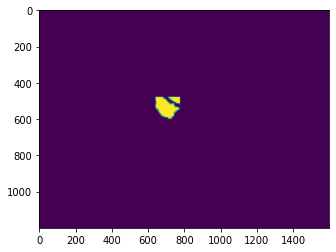

In [31]:
from PIL import Image
chm = targets[0]['masks'][0].detach().cpu().numpy()
chm.shape
# Image.fromarray(chm)
import matplotlib.pyplot as plt
plt.imshow(chm)

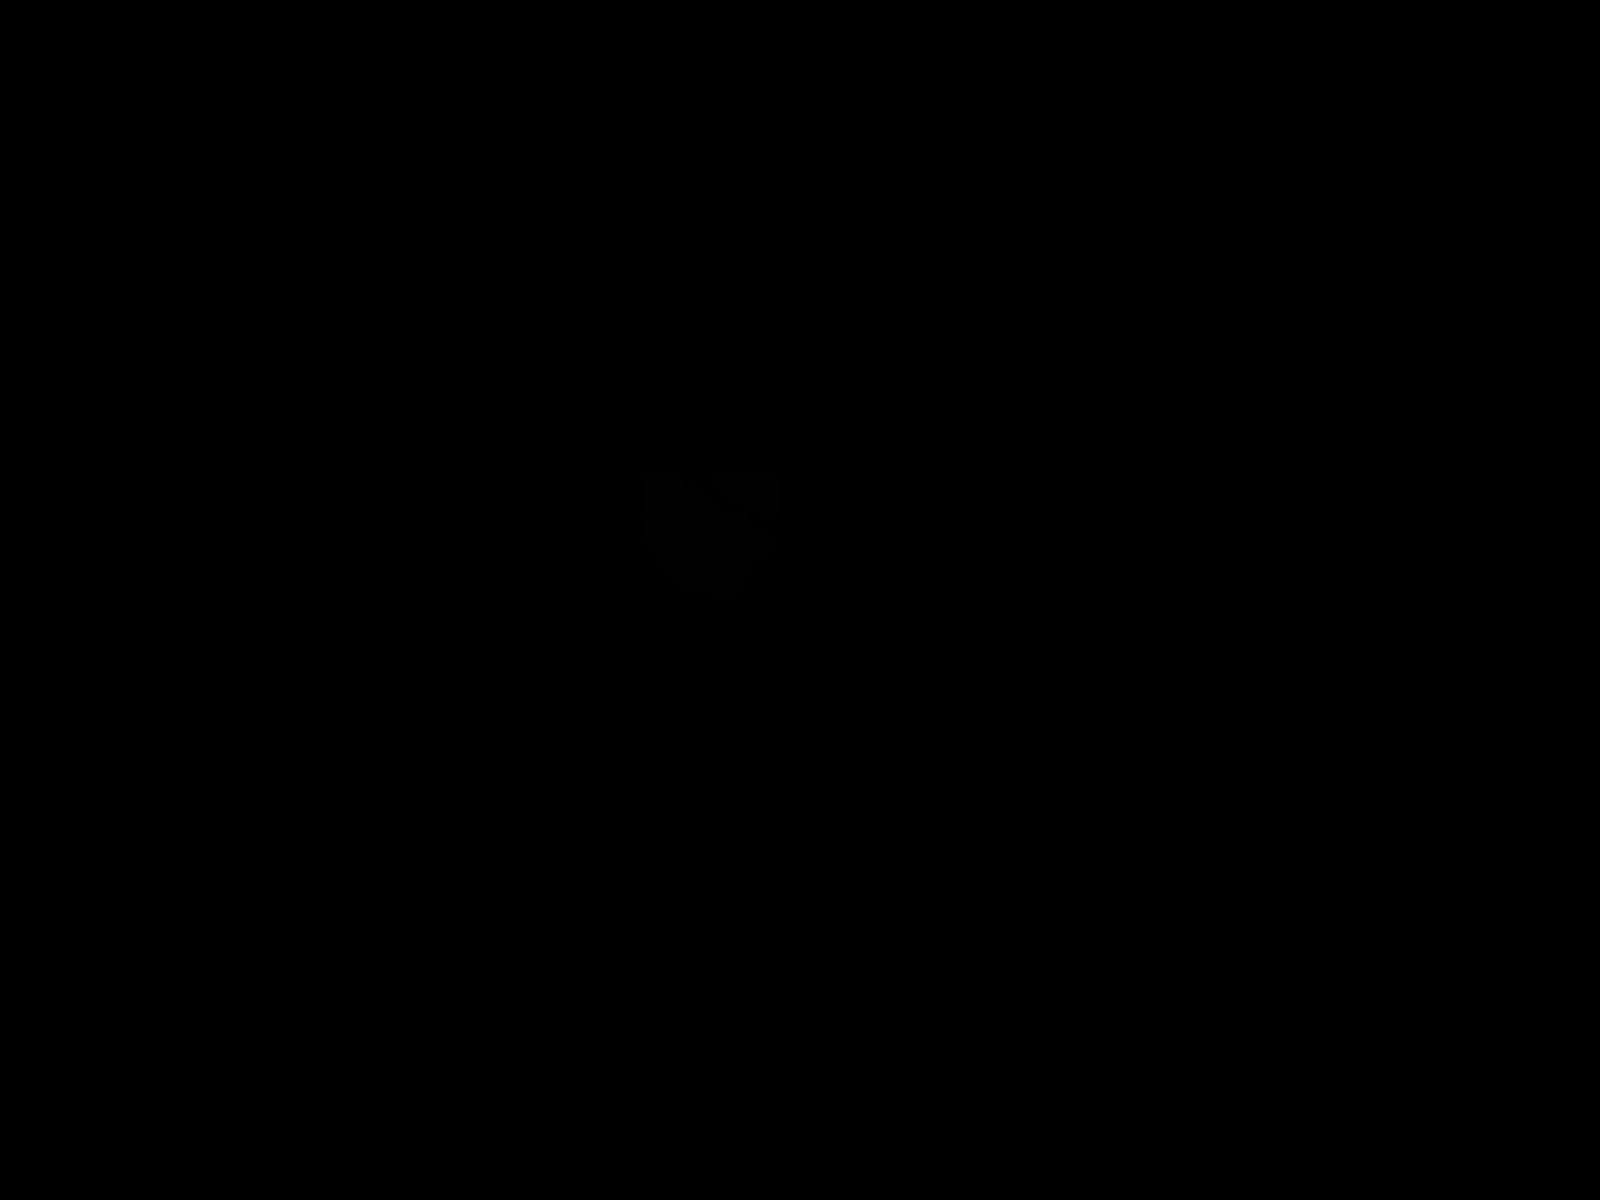

In [32]:
mask = F.to_pil_image(targets[0]['masks'].detach().cpu())
mask

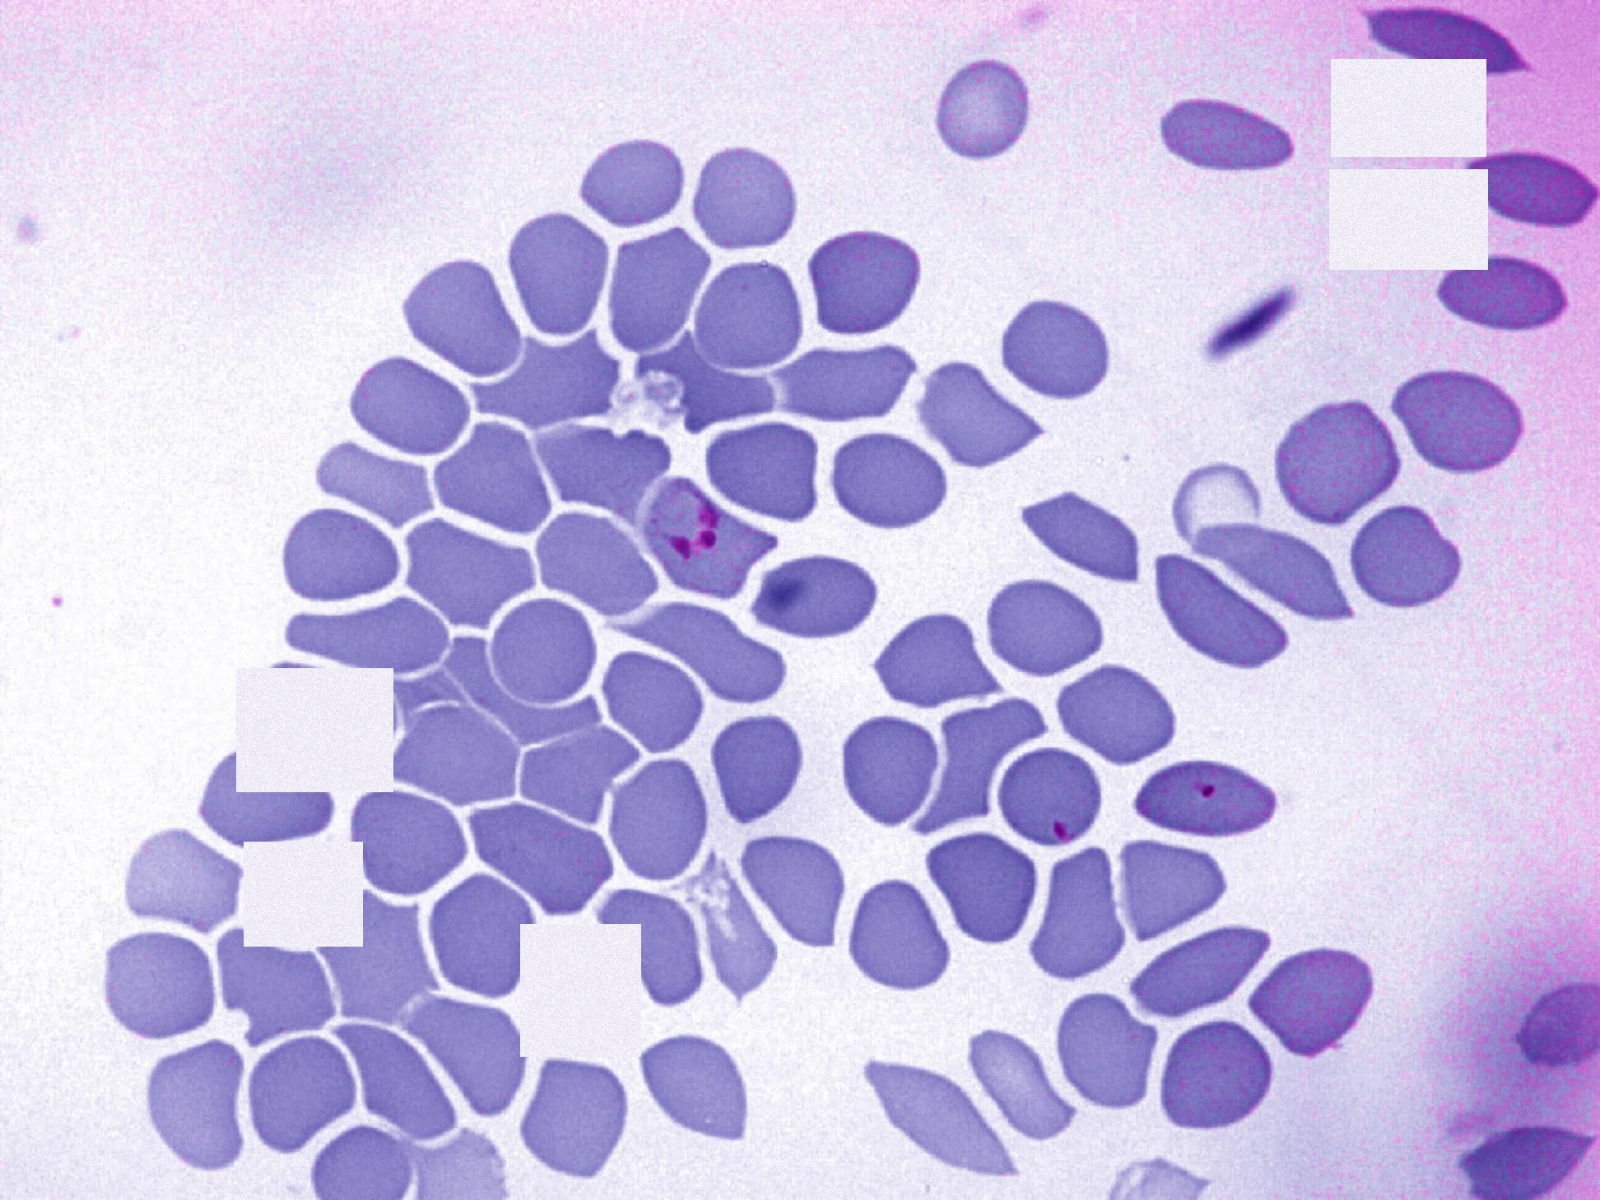

In [33]:
im = F.to_pil_image(images[0].detach().cpu())
im

In [34]:
from PIL import Image, ImageDraw

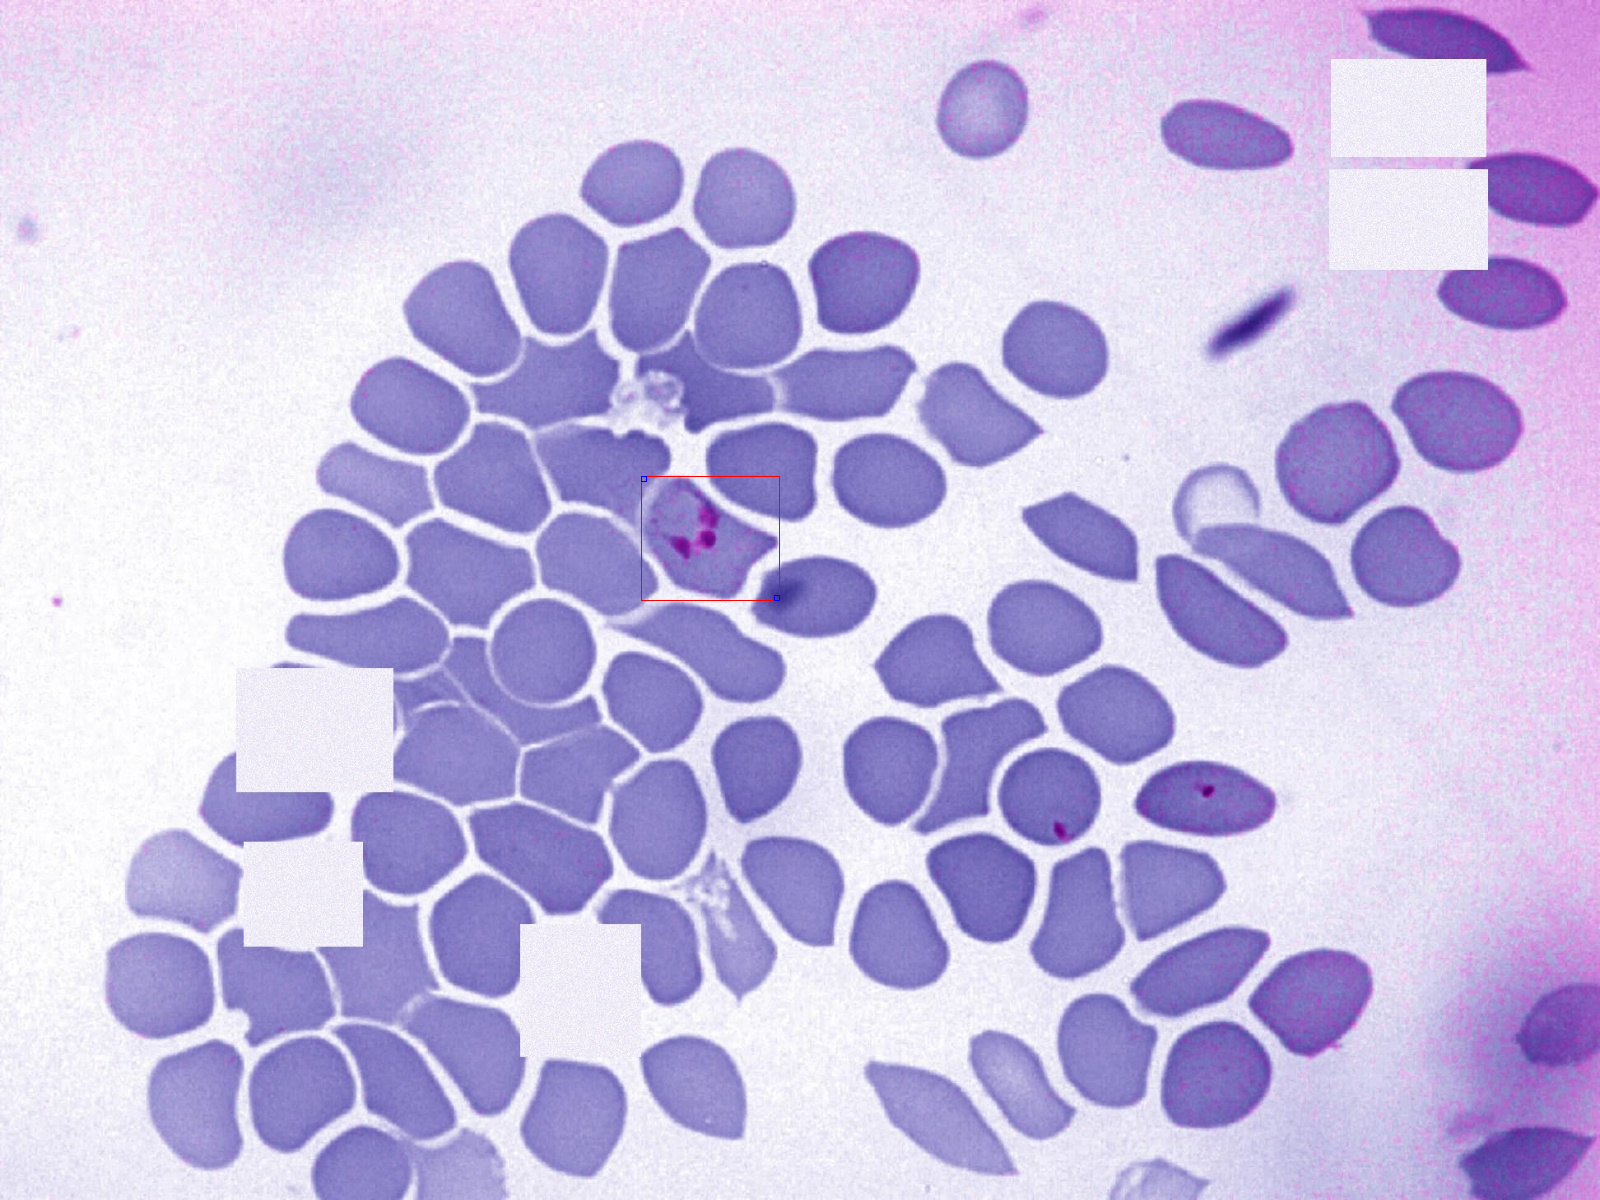

In [35]:
img1 = ImageDraw.Draw(im)
lx,ly,ux,uy = targets[0]['boxes'][0].detach().cpu().numpy()
shape = [(lx,ly),(ux,uy)]
img1.rectangle(shape,outline ="red")
shape = [(ux-5,uy-5),(ux,uy)]
img1.rectangle(shape,outline ="blue")
shape = [(lx,ly),(lx+5,ly+5)]
img1.rectangle(shape,outline ="blue")
im

In [36]:
model.train()
output = model(images,targets)

In [63]:
for name,value in zip(output.keys(),output.values()):
    print(name,value.item())

loss_classifier 1.6010098457336426
loss_box_reg 0.010059473104774952
loss_mask 1.7833596467971802
loss_objectness 0.06839291006326675
loss_rpn_box_reg 0.013253932818770409


In [58]:
printdata = utils.reduce_dict(output)
printdata

{'loss_classifier': tensor(1.6010, device='cuda:0', grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.0101, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_mask': tensor(1.7834, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_objectness': tensor(0.0684, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0133, device='cuda:0', grad_fn=<DivBackward0>)}

In [38]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = hparams.num_epochs

for epoch in range(1):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader, device=device)

Epoch: [0]  [  0/154]  eta: 0:02:22  lr: 0.000038  loss: 3.9308 (3.9308)  loss_classifier: 1.7039 (1.7039)  loss_box_reg: 0.0450 (0.0450)  loss_mask: 2.1461 (2.1461)  loss_objectness: 0.0312 (0.0312)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 0.9236  data: 0.5547  max mem: 5217
Epoch: [0]  [ 10/154]  eta: 0:00:54  lr: 0.000364  loss: 1.7806 (2.0394)  loss_classifier: 1.1688 (1.0646)  loss_box_reg: 0.0278 (0.0225)  loss_mask: 0.7908 (0.9002)  loss_objectness: 0.0396 (0.0450)  loss_rpn_box_reg: 0.0051 (0.0070)  time: 0.3812  data: 0.0643  max mem: 5495
Epoch: [0]  [ 20/154]  eta: 0:00:46  lr: 0.000691  loss: 0.6873 (1.3648)  loss_classifier: 0.1544 (0.5980)  loss_box_reg: 0.0245 (0.0238)  loss_mask: 0.4296 (0.6765)  loss_objectness: 0.0434 (0.0588)  loss_rpn_box_reg: 0.0048 (0.0077)  time: 0.3220  data: 0.0144  max mem: 5495
Epoch: [0]  [ 30/154]  eta: 0:00:42  lr: 0.001017  loss: 0.5820 (1.0855)  loss_classifier: 0.0955 (0.4340)  loss_box_reg: 0.0245 (0.0251)  loss_mask: 0.4026 (0.5688) 

torch.Tensor

In [40]:
ev = evaluate(model, data_loader, device=device)

creating index...
index created!
Test:  [  0/154]  eta: 0:06:24  model_time: 0.9453 (0.9453)  evaluator_time: 0.8197 (0.8197)  time: 2.4953  data: 0.6631  max mem: 5965
Test:  [100/154]  eta: 0:01:51  model_time: 1.0054 (1.0876)  evaluator_time: 0.8071 (0.8983)  time: 1.9640  data: 0.0159  max mem: 5965
Test:  [153/154]  eta: 0:00:02  model_time: 1.0363 (1.0573)  evaluator_time: 0.9161 (0.8634)  time: 1.9478  data: 0.0147  max mem: 5965
Test: Total time: 0:05:09 (2.0107 s / it)
Averaged stats: model_time: 1.0363 (1.0573)  evaluator_time: 0.9161 (0.8634)
Accumulating evaluation results...
DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.39s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000


In [50]:
model(images,targets)

KeyError: 0